In [2]:
import random
import time
from rangeindex import RangeIndex
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [34]:
alpha = 'qwertyuiopasdfghjklzxcvbnmQWERTYUIOPASDFGHJKLZXCVBNM1234567890!@#$%^&*();.,<> 🧳 🌂 ☂️ 🧵 🪡 🪢 🧶 👓 🕶 🥽 🥼 🦺 👔 👕 👖 🧣 🧤 🩱 🩲 🩳 👙 '
nums = list(range(10**4))
w_length = 10

class Thing():
    def __init__(self):
        self.c0 = random.choice(alpha)
        self.c1 = random.choice(alpha)
        self.w0 = ''.join(random.choice(alpha) for _ in range(w_length))
        self.w1 = ''.join(random.choice(alpha) for _ in range(w_length))
        
things = [Thing() for _ in range(10**6)]

In [35]:
len(set(alpha))

100

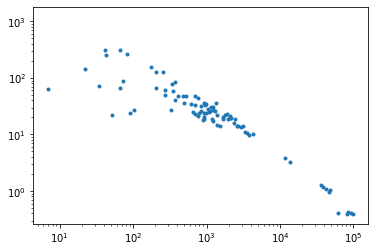

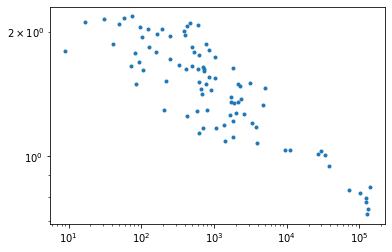

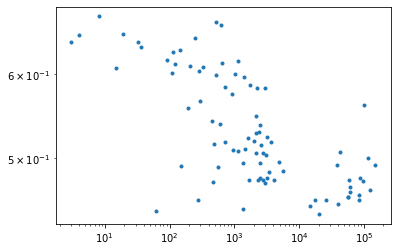

In [60]:
for engine in ['sqlite', 'duckdb', 'pandas']:
    ri = RangeIndex({'w0': str, 'w1': str}, things, engine=engine)
    x = []
    y = []
    for kk in range(100):
        # just make up random words
        c = random.choice(alpha)
        lo = c
        hi = c
        for i in range(random.choice([1,2,3,4,5])):
            lo = lo + random.choice(alpha)
            hi = hi + random.choice(alpha)
        if lo > hi:
            lo, hi = hi, lo
        t0 = time.time()
        res = ri.find(f"w0 < '{hi}' and w0 > '{lo}' and w1 > '{lo}'")
        t1 = time.time()
        lin = [t for t in things if t.w0 < hi and t.w0 > lo and t.w1 > lo]
        t2 = time.time()
        if kk > 10:
            x.append(len(lin))
            y.append((t2-t1) / (t1-t0))

    plt.loglog(x, y, '.')
    plt.show()


Let's benchmark on some strings!

In [3]:
def generate_word_range(n_results=1, n_idx=1, dataset_size=10**6) -> tuple[float, float]:
    """
    Generate a range of float values that, when queried, will return approx n_results items.
    Example: if n_idx is 1, and we want 1/10 of the items in the dataset, we could return (0.5, 0.6)
    as that will be 1/10 of the items.
    But if n_idx is 2, we want a range of 0.1**(1/2) items, to account for the fact that we have 
    two independent value ranges.
    """
    width = (n_results / dataset_size)**(1/n_idx)
    lim_1 = random.random()*(1-width)
    lim_2 = lim_1 + width
    return lim_1, lim_2


In [4]:
def bench_floats(n_idx=1, n_runs=5):
    results = {}
    n_runs = 10
    fields = {f'f{i}': float for i in range(n_idx)}
    ris = []
    for engine in ['pandas', 'sqlite', 'duckdb']:
        ri = RangeIndex(fields, things, engine)
        ris.append(ri)
    ris.append('linear')
    for ri in ris:
        for n_items in [10**e for e in range(0, 7)]:
            # Run 2 bechmarks, take the second. Queries are randomized so this isn't a cache cheat.
            # Rather, this gives a "warm-up" round so that the data more accurately reflects
            # the performance you'd get at steady-state.
            # Without this, you get really weird distorted data.
            for _ in range(2):  
                t_tot = 0
                n_tot = 0
                for run in range(n_runs):
                    lo, hi = generate_float_range(n_items, n_idx)
                    if ri == 'linear':
                        q = ' and '.join([
                            f't.f{i} > {lo} and t.f{i} <= {hi}'
                            for i in range(n_idx)
                        ])
                        t0 = time.time()
                        items_got = eval(f'[t for t in things if {q}]')
                        t1 = time.time()
                    else:
                        q = ' and '.join([
                            f'f{i} > {lo} and f{i} <= {hi}'
                            for i in range(n_idx)
                        ])
                        t0 = time.time()
                        items_got = ri.find(q)
                        t1 = time.time()
                    t_tot += (t1-t0) / n_runs
                    n_tot += len(items_got) / n_runs
                if ri == 'linear':
                    cond = 'linear'
                else:
                    cond = ri.engine
                results[(cond, n_items)] = {'got': n_tot, 'time': t_tot}

    return results

In [5]:
# raw numbers, much better for tweaking

for n_idx in [2]:
    results = bench_floats(n_idx=n_idx)
    plt.figure(figsize=(20,10))
    if n_idx == 1:
        title = '1 field indexed'
    else:
        title = f'{n_idx} fields indexed'
    print(title)

    for i, engine in enumerate(['pandas', 'sqlite', 'duckdb']):
        for n_items in [10**e for e in range(0, 7)]:
            baseline = results[('linear', n_items)]['time']
            result = results[(engine, n_items)]['time']
            speedup = round(baseline/result, 3)
            print(f'{engine}, {n_items}: {result}')


2 fields indexed
pandas, 1: 0.004731225967407226
pandas, 10: 0.004625105857849122
pandas, 100: 0.004607462882995605
pandas, 1000: 0.005123090744018555
pandas, 10000: 0.00743570327758789
pandas, 100000: 0.01964116096496582
pandas, 1000000: 0.036014246940612796
sqlite, 1: 0.0007136106491088867
sqlite, 10: 0.0021960258483886713
sqlite, 100: 0.006836581230163575
sqlite, 1000: 0.02139725685119629
sqlite, 10000: 0.07566063404083252
sqlite, 100000: 0.25985381603240965
sqlite, 1000000: 0.6651187419891357
duckdb, 1: 0.07871429920196533
duckdb, 10: 0.077453351020813
duckdb, 100: 0.11546671390533447
duckdb, 1000: 0.11321823596954346
duckdb, 10000: 0.09496791362762451
duckdb, 100000: 0.1352240800857544
duckdb, 1000000: 0.2259279251098633


<Figure size 1440x720 with 0 Axes>

2 fields indexed


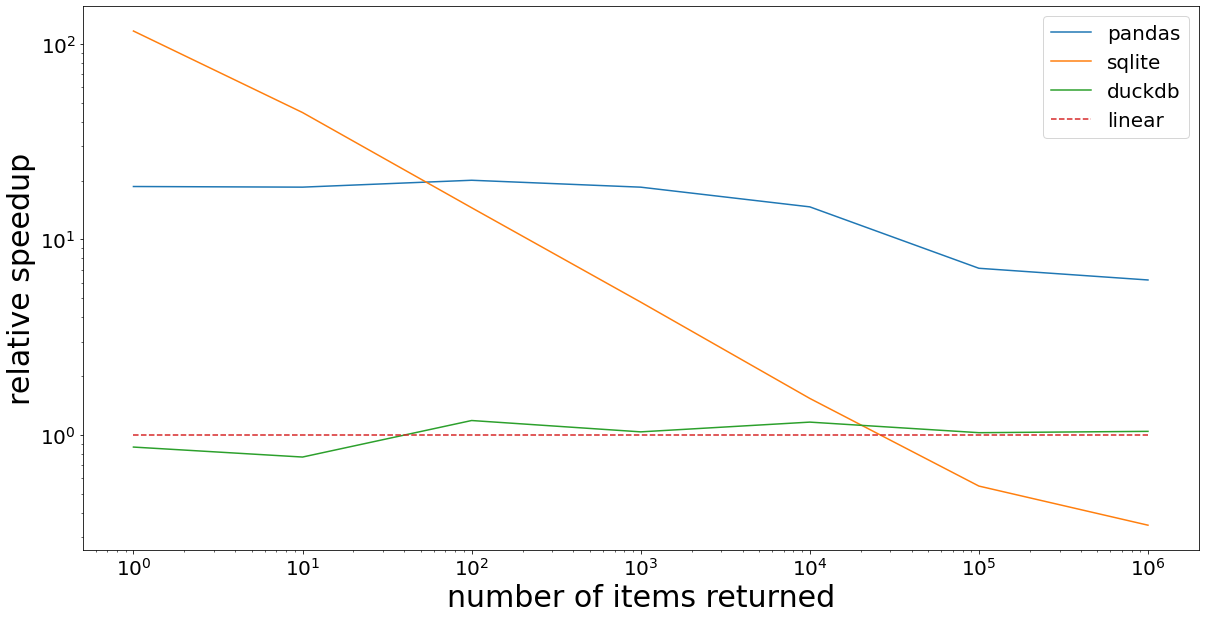

In [6]:
matplotlib.rc('font', size=20)

# for n_idx in [1, 2, 5, 10]:
for n_idx in [2]:
    results = bench_floats(n_idx=n_idx)
    plt.figure(figsize=(20,10))
    if n_idx == 1:
        title = '1 field indexed'
    else:
        title = f'{n_idx} fields indexed'
    print(title)
    # plt.title(f'{title}', fontsize=30)

    for i, engine in enumerate(['pandas', 'sqlite', 'duckdb']):
        x = []
        y = []
        for n_items in [10**e for e in range(0, 7)]:
            baseline = results[('linear', n_items)]['time']
            result = results[(engine, n_items)]['time']
            speedup = round(baseline/result, 3)
            #print(f'{engine}, {n_items}: {speedup}x')
            x.append(n_items)
            y.append(speedup)
        plt.loglog(x, y, label=engine)
        plt.xlabel('number of items returned')
        plt.ylabel('relative speedup')
    plt.loglog([1, 10**6], [1, 1], '--', label='linear')
    plt.xlabel('number of items returned', fontsize=30)
    plt.ylabel('relative speedup', fontsize=30)
    plt.legend()
    plt.show()

In [7]:
# quick check, how much of that is dict lookup?
obj_ids = [id(t) for t in things]
obj_dict = {id(t): t for t in things}

t0 = time.time()
zz = [obj_dict[obj_id] for obj_id in obj_ids[:len(obj_ids)//10]]
t1 = time.time()
print('dict lookup of 100K items:', t1-t0)

t0 = time.time()
zz = [obj_dict[obj_id] for obj_id in obj_ids]
t1 = time.time()
print('dict lookup of 1M items:', t1-t0)

dict lookup of 100K items: 0.010614156723022461
dict lookup of 1M items: 0.12601613998413086


In [8]:
(0.408)/(0.408-0.1179*5/6)

1.3171912832929782